This notebook clips 1 hectare and appropriate plot-sized clips for USFS plots within the Mount Adams 2016 lidar acquisition, 1 plot that fills within the Yakima K2K-2014 acquisition, and three plots that fall within the DNR-Klickitat_2015 lidar acquisition.

In [1]:
import geopandas as gpd
import pandas as pd
import glob
import os
import subprocess
from functools import partial
import dask
from dask.distributed import Client, LocalCluster, progress
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
MTADAMS_SHP = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/mt-adams_2016/mt-adams_2016_tiles_with_usfs_plots.shp'
mtadams_tiles = gpd.read_file(MTADAMS_SHP)
mtadams_tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 12 columns):
file_name     155 non-null object
version       155 non-null object
num_points    155 non-null int64
point_type    155 non-null int64
point_size    155 non-null int64
min_x         155 non-null float64
max_x         155 non-null float64
min_y         155 non-null float64
max_y         155 non-null float64
min_z         155 non-null float64
max_z         155 non-null float64
geometry      155 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 14.6+ KB


In [3]:
mtadams_tiles = mtadams_tiles[['file_name', 'geometry']]
mtadams_tiles.crs

{'init': 'epsg:2927'}

In [4]:
HA_PLOTS_SHP = '../data/processed/blm_usfs_wadnr_plots_1ha.shp'
plots = gpd.read_file(HA_PLOTS_SHP)
plots = plots.loc[plots.source.str.contains('USFS')]
plots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1223 entries, 0 to 1222
Data columns (total 10 columns):
comments     0 non-null object
lat          1223 non-null float64
lon          1223 non-null float64
meas_date    0 non-null object
orig_id      1223 non-null object
plot_id      0 non-null object
source       1223 non-null object
meas_yr      1223 non-null int64
uuid         1223 non-null object
geometry     1223 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 105.1+ KB


In [5]:
sp_plots = plots.to_crs({'init': 'epsg:2927'})
sp_plots['x'] = sp_plots.centroid.x
sp_plots['y'] = sp_plots.centroid.y
sp_plots = sp_plots[['uuid','x','y', 'geometry']].set_index('uuid')

In [6]:
sp_plots.crs, mtadams_tiles.crs

({'init': 'epsg:2927'}, {'init': 'epsg:2927'})

In [7]:
joined = gpd.sjoin(sp_plots, mtadams_tiles)[['x', 'y', 'file_name']]

In [8]:
@dask.delayed
def clip_1ha_plot(uuid, acq_name, tile_dir, odir):
    basename = '{}_{}.laz'.format(uuid, acq_name)
    outfile = os.path.join(odir, basename)
    
    match = sp_plots.loc[uuid][['x', 'y']]
    x, y = match.x, match.y
    intersecting_tiles = joined.loc[uuid][['file_name']].values.flatten()
    
    tiles = [os.path.join(tile_dir, t) for t in intersecting_tiles]
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                           '-i', *tiles, '-merged',
                           '-o', outfile,
                           # 1ha plot radius in feet
                           '-keep_circle', str(x), str(y), '185.1'], 
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile)
    return proc

In [9]:
@dask.delayed
def clip_smaller_plot(infile, odir):
    basename = os.path.basename(infile)
    outfile = os.path.join(odir, basename)
    
    uuid = basename.split('_')[0]
    match = sp_plots.loc[uuid][['x', 'y']]
    x, y = match.x, match.y
    
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                           '-i', infile,
                           '-o', outfile,
                           # 1/4 acre plot radius in feet
                           '-keep_circle', str(x), str(y), '58.9'], 
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile)
    return proc

In [10]:
@dask.delayed
def get_boundary(infile, odir):
    proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/lasboundary.exe',
                           '-i', infile,
                           '-odir', odir,
                           '-oshp',
                           '-labels'], 
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
#     print(outfile)
    return proc

In [11]:
cluster=LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)

In [12]:
uuids = pd.unique(joined.index)
TILE_DIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/mt-adams_2016/tiles_epsg2927/'
ODIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/'
clip_1ha = partial(clip_1ha_plot, acq_name='mt-adams_2016', tile_dir=TILE_DIR, odir=ODIR)

res = c.persist([clip_1ha(i) for i in uuids])
progress(res)

VBox()

In [ ]:
# c.cancel(res)

In [13]:
yak_plot = sp_plots.loc['50ef6d0c-d1ed-42f4-8e72-1f8572d02e79']
yak_plot

x                                                 1.49784e+06
y                                                      663999
geometry    POLYGON ((1498085.1413097 664003.9091376604, 1...
Name: 50ef6d0c-d1ed-42f4-8e72-1f8572d02e79, dtype: object

In [14]:
x, y = yak_plot.x, yak_plot.y

INFILE = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/yakima-k2k_2014/tiles_epsg2927/Yakima_000879.laz'
HA_OUTFILE = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/50ef6d0c-d1ed-42f4-8e72-1f8572d02e79_yakima-k2k_2014.laz'

ha_proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                          '-i', INFILE,
                          '-o', HA_OUTFILE,
                          # 1ha plot radius in feet
                          '-keep_circle', str(x), str(y), '185.1'], 
                         stderr=subprocess.PIPE,
                         stdout=subprocess.PIPE)

PLOT_OUTFILE = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/plot_clips_epsg2927/50ef6d0c-d1ed-42f4-8e72-1f8572d02e79_yakima-k2k_2014.laz'
plot_proc = subprocess.run(['wine', '/storage/lidar/LAStools/bin/las2las.exe',
                            '-i', HA_OUTFILE,
                            '-o', PLOT_OUTFILE,
                            # 1/4 acre plot radius in feet
                            '-keep_circle', str(x), str(y), '58.9'],
                           stderr=subprocess.PIPE,
                           stdout=subprocess.PIPE)

ha_proc, plot_proc

(CompletedProcess(args=['wine', '/storage/lidar/LAStools/bin/las2las.exe', '-i', '../data/raw/lidar/dnr_portal/dnr_portal_tiles/yakima-k2k_2014/tiles_epsg2927/Yakima_000879.laz', '-o', '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/50ef6d0c-d1ed-42f4-8e72-1f8572d02e79_yakima-k2k_2014.laz', '-keep_circle', '1497841.2161545136', '663999.1072647399', '185.1'], returncode=0, stdout=b'', stderr=b''),
 CompletedProcess(args=['wine', '/storage/lidar/LAStools/bin/las2las.exe', '-i', '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/50ef6d0c-d1ed-42f4-8e72-1f8572d02e79_yakima-k2k_2014.laz', '-o', '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/plot_clips_epsg2927/50ef6d0c-d1ed-42f4-8e72-1f8572d02e79_yakima-k2k_2014.laz', '-keep_circle', '1497841.2161545136', '663999.1072647399', '58.9'], returncode=0, stdout=b'', stderr=b''))

In [15]:
KLICK_SHP = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/dnr-klickitat_2015/dnr-klickitat_2015_tiles_with_usfs_plots.shp'
klick_tiles = gpd.read_file(KLICK_SHP)
klick_tiles.crs, klick_tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 12 columns):
file_name     3 non-null object
version       3 non-null object
num_points    3 non-null int64
point_type    3 non-null int64
point_size    3 non-null int64
min_x         3 non-null float64
max_x         3 non-null float64
min_y         3 non-null float64
max_y         3 non-null float64
min_z         3 non-null float64
max_z         3 non-null float64
geometry      3 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 368.0+ bytes


({'init': 'epsg:2927'}, None)

In [16]:
joined = gpd.sjoin(sp_plots, klick_tiles)[['x', 'y', 'file_name']]
joined

,x,y,file_name
6a58bde4-1620-4085-a3cf-8561d3a91b51,1.350166e+06,201230.758782,q45121h6424.laz
95257f68-148e-47dc-9fa6-4f40e29563c2,1.352443e+06,201255.644842,q45121h6425.laz
df4de597-4a16-400d-9aed-4b9107b5d969,1.363657e+06,201330.561863,q45121h5324.laz


In [17]:
uuids = pd.unique(joined.index)
TILE_DIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/dnr-klickitat_2015/tiles_epsg2927/'
ODIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/'
clip_1ha = partial(clip_1ha_plot, acq_name='dnr-klickitat_2015', tile_dir=TILE_DIR, odir=ODIR)

res = c.persist([clip_1ha(i) for i in uuids])
progress(res)

VBox()

In [18]:
ha_clips = glob.glob(os.path.join(ODIR, '*.laz'))
# set new ODIR for plot-sized clips
ODIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/plot_clips_epsg2927/'
res = c.persist([clip_smaller_plot(f, odir=ODIR) for f in ha_clips])
progress(res)

VBox()

In [19]:
PLOT_CLIPS = os.path.join(ODIR, '*.laz')
clipped = glob.glob(PLOT_CLIPS)
len(clipped)

105

In [20]:
res = c.persist([get_boundary(p, odir=ODIR) for p in clipped])
progress(res)

VBox()

In [21]:
HA_ODIR = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/'
HA_PLOT_CLIPS = os.path.join(HA_ODIR, '*.laz')
ha_clipped = glob.glob(HA_PLOT_CLIPS)
len(ha_clipped)

105

In [22]:
res = c.persist([get_boundary(p, odir=HA_ODIR) for p in ha_clipped])
progress(res)

VBox()

In [23]:
# c.close()
# cluster.close()

In [24]:
# inspect coverages
SHPS = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/plot_clips_epsg2927/*.shp'
shps = glob.glob(SHPS)
len(shps)

105

In [25]:
# read in all the shapefiles of clipped plot boundaries into a list
gdfs = [gpd.read_file(shp) for shp in shps]
# concatentate them into a single geodataframe
gdf = pd.concat(gdfs, axis=0, ignore_index=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
file_name     105 non-null object
version       105 non-null object
num_points    105 non-null int64
point_type    105 non-null int64
point_size    105 non-null int64
min_x         105 non-null float64
max_x         105 non-null float64
min_y         105 non-null float64
max_y         105 non-null float64
min_z         105 non-null float64
max_z         105 non-null float64
geometry      105 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 9.9+ KB


In [26]:
# inspect coverages
HA_SHPS = '../data/raw/lidar/dnr_portal/dnr_portal_tiles/usfs_plots/hectare_clips_epsg2927/*.shp'
ha_shps = glob.glob(HA_SHPS)
len(ha_shps)

105

In [27]:
# read in all the shapefiles of clipped plot boundaries into a list
ha_gdfs = [gpd.read_file(shp) for shp in ha_shps]
# concatentate them into a single geodataframe
ha_gdf = pd.concat(ha_gdfs, axis=0, ignore_index=True)
ha_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
file_name     105 non-null object
version       105 non-null object
num_points    105 non-null int64
point_type    105 non-null int64
point_size    105 non-null int64
min_x         105 non-null float64
max_x         105 non-null float64
min_y         105 non-null float64
max_y         105 non-null float64
min_z         105 non-null float64
max_z         105 non-null float64
geometry      105 non-null object
dtypes: float64(6), int64(3), object(3)
memory usage: 9.9+ KB


In [28]:
gdf['acres'] = gdf.area / 43560  # sq ft per acre
ha_gdf['acres'] = ha_gdf.area / 43560

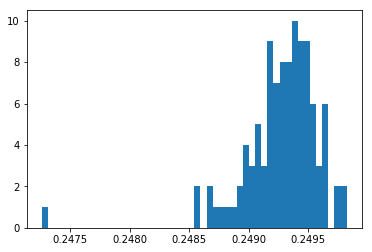

In [29]:
plt.hist(gdf.acres, bins=50);

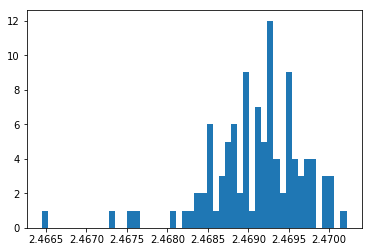

In [30]:
plt.hist(ha_gdf.acres, bins=50);